# part 1

In [1]:
import numpy as np
import time

n1 = 400

# exponentially decaying sinusoids with different frequencies
inp = np.zeros(n1, dtype=np.float32)
for j in range(n1 // 15, n1, n1 // 5):
    wave = np.zeros(n1, dtype=np.float32)
    for x in range(j, 399):
        y = (x - j) / 400
        wave[x] = np.exp(-y * 15) * np.sin(y * 0.95 * j)
    inp += wave

res = np.copy(inp)
bak = np.copy(inp)


In [2]:
import matplotlib.pyplot as plt


In [3]:
def stems(data, label, color):
    """
    Plot data using stems (stem plot).
    """
    n1 = len(data)

    # Create a plot with initial zeros
    plt.plot(np.zeros(n1), label=None, color='black')

    # Create a stem plot
    plt.stem(data, label=label, linefmt=color, markerfmt=' ', basefmt=" ")

    # Add legend and formatting
    plt.legend(loc='upper left')
    plt.xlim([0.5, n1 + 0.5])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Show the plot
    plt.show()

In [4]:
def stems(data, label, color):
    """
    Plot data using stems (stem plot).
    """
    n1 = len(data)

    # Create a plot with initial zeros
    plt.plot(np.zeros(n1), label=None, color='black')

    # Create a stem plot
    # plt.stem(data, label=label, linefmt=color, markerfmt=' ', basefmt=" ", use_line_collection=True)
    plt.stem(data, label=label, linefmt=color, markerfmt=' ', basefmt=" ")

    # Add legend and formatting
    plt.legend(loc='upper left')
    plt.xlim([0.5, n1 + 0.5])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Show the plot
    plt.show()

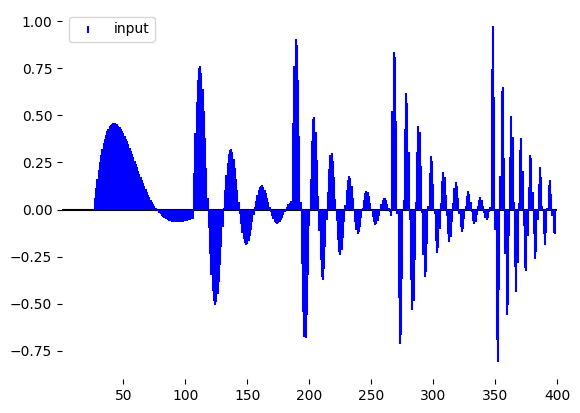

In [5]:
plot_input = stems(inp, "input", "blue")


In [6]:
def stream(inv, d, r, na, lambd):
    """
    Streaming PEF algorithm.

    Parameters:
    inv (bool): Direction of streaming, from r to d (True) or d to r (False).
    d (np.ndarray): Input/output data vector.
    r (np.ndarray): Output/input data vector.
    na (int): Number of coefficients.
    lambd (float): Lambda parameter (λ).
    """
    a = np.zeros(na)  # streaming PEF
    dd = da = 0.0  # d (dot) d, d (dot) a

    for ia in range(na):
        if inv:
            d[ia] = r[ia]
        else:
            r[ia] = d[ia]
        dd += d[ia] * d[ia]

    for i1 in range(na, len(d)):
        if inv:  # from r to d
            rn = r[i1] / lambd
            dn = rn * (lambd + dd) - da
            d[i1] = dn
        else:  # from d to r
            dn = d[i1]
            rn = (dn + da) / (lambd + dd)
            r[i1] = lambd * rn

        # update PEF
        for ia in range(na):
            a[ia] -= rn * d[i1 - ia - 1]

        # update dd and da
        dd += dn * dn - d[i1 - na] * d[i1 - na]
        da = dn * a[0]
        for ia in range(1, na):
            da += a[ia] * d[i1 - ia]


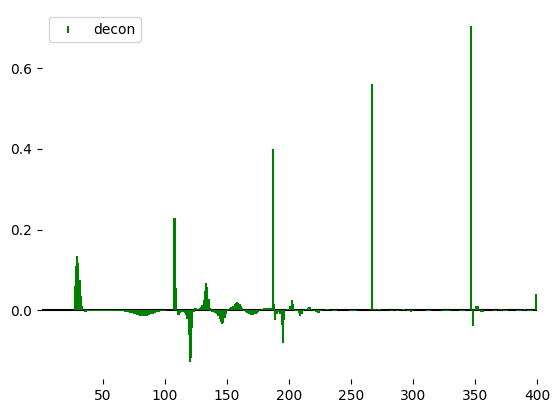

In [7]:
# Call the stream function
stream(False, inp, res, 2, 0.1)

# Create the stem plot for the result
plot_decon = stems(res, "decon", "green")


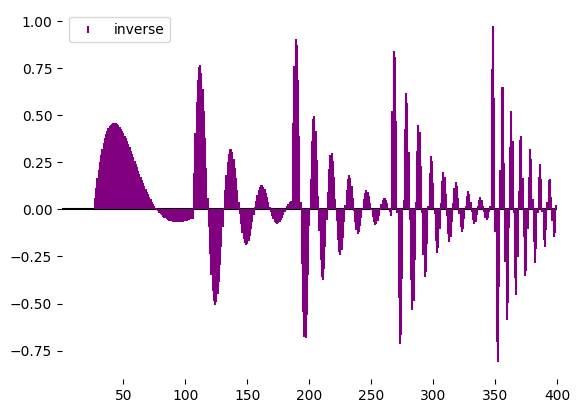

In [8]:
# Call the stream function with inverse set to True
stream(True, bak, res, 2, 0.1)

# Create the stem plot for the inverse result
plot_inverse = stems(bak, "inverse", "purple")


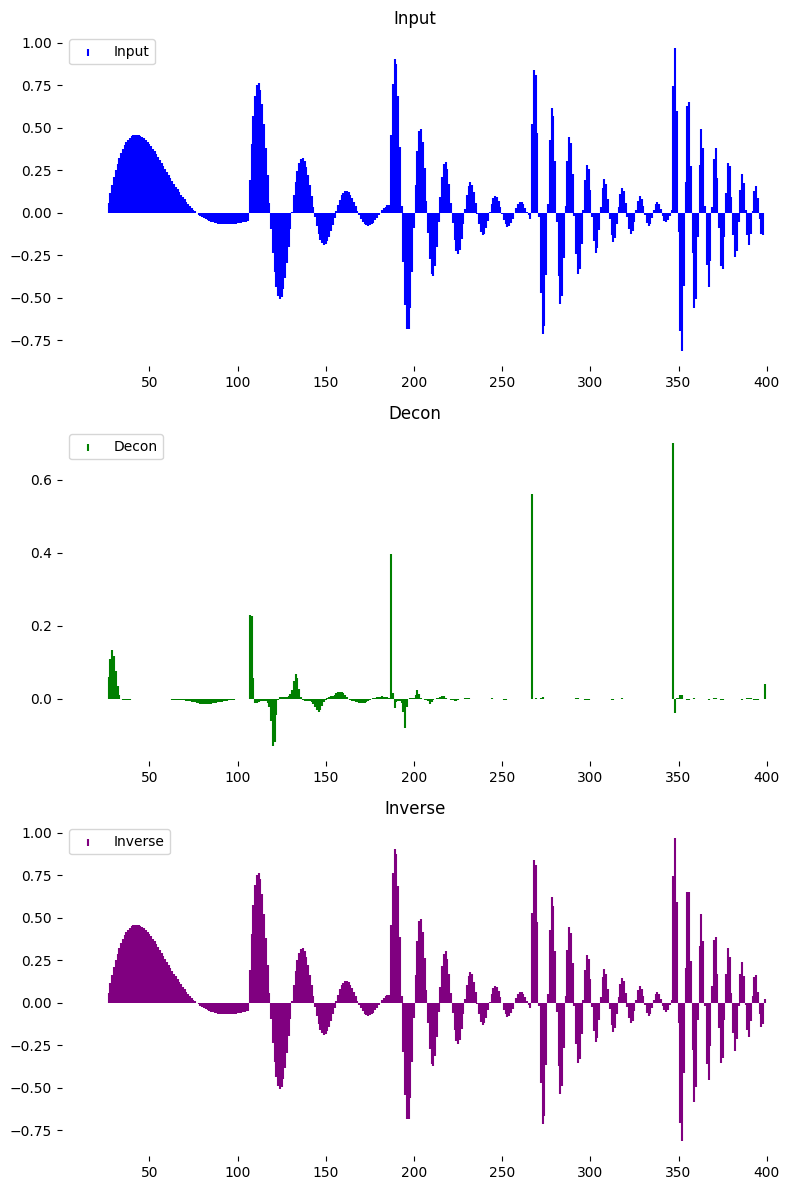

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

# Create subplots with a layout of 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Adjust figsize as needed

# Plot the input data
# axs[0].stem(inp, linefmt='blue', markerfmt=' ', basefmt=" ", use_line_collection=True)
axs[0].stem(inp, linefmt='blue', markerfmt=' ', basefmt=" ")
axs[0].set_title("Input")
axs[0].set_xlim([0.5, len(inp) + 0.5])
axs[0].legend(["Input"], loc='upper left')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Plot the decon data
# axs[1].stem(res, linefmt='green', markerfmt=' ', basefmt=" ", use_line_collection=True)
axs[1].stem(res, linefmt='green', markerfmt=' ', basefmt=" ")
axs[1].set_title("Decon")
axs[1].set_xlim([0.5, len(res) + 0.5])
axs[1].legend(["Decon"], loc='upper left')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

# Plot the inverse data
# axs[2].stem(bak, linefmt='purple', markerfmt=' ', basefmt=" ", use_line_collection=True)
axs[2].stem(bak, linefmt='purple', markerfmt=' ', basefmt=" ")
axs[2].set_title("Inverse")
axs[2].set_xlim([0.5, len(bak) + 0.5])
axs[2].legend(["Inverse"], loc='upper left')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

plt.savefig("stream.pdf")

In [10]:
plt.savefig("stream.pdf")

<Figure size 640x480 with 0 Axes>

### Multiple dimensions

In [11]:
# Create a deepcopy of inp
inp2 = np.copy(inp)
known = np.ones(n1, dtype=bool)

# Cut holes in the data and create a mask
holes = [55, 153, 246, 301, 376]
for hole in holes:
    inp2[hole:hole + 20] = 0  # Note: Python slicing is exclusive of the end index
    known[hole:hole + 20] = False


In [12]:
def stream_missing(d, k, na, lambd):
    """
    Streaming PEF with missing data handling.

    Parameters:
    d (np.ndarray): Input/output data vector.
    k (np.ndarray): Boolean mask indicating known values.
    na (int): Number of coefficients.
    lambd (float): Lambda parameter (λ).
    """
    a = np.zeros(na)  # streaming PEF
    da = 0.0  # d (dot) a
    dd = 0.0  # d (dot) d

    for ia in range(na):
        dd += d[ia] * d[ia]

    for i1 in range(na, len(d)):
        if k[i1]:  # from d to r
            dn = d[i1]
            rn = (dn + da) / (lambd + dd)
        else:  # assume r=0
            dn = -da
            rn = 0.0
            d[i1] = dn

        # update PEF
        for ia in range(na):
            a[ia] -= rn * d[i1 - ia - 1]

        # update dd and da
        dd += dn * dn - d[i1 - na] * d[i1 - na]
        da = dn * a[0]
        for ia in range(1, na):
            da += a[ia] * d[i1 - ia]


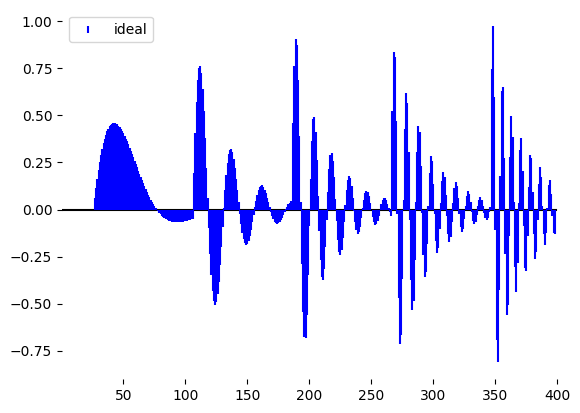

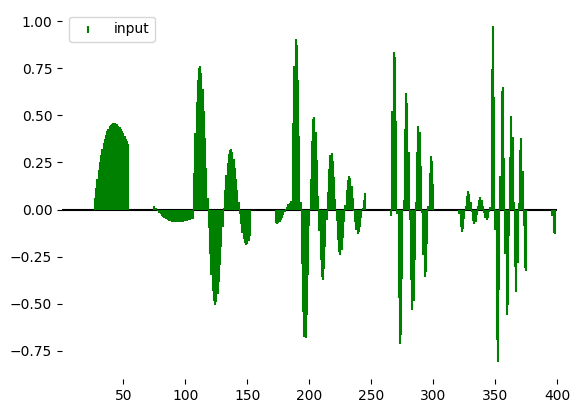

In [13]:
# Create the stem plot for the ideal data
plot_ideal = stems(inp, "ideal", "blue")

# Create the stem plot for the input with holes
plot_hole = stems(inp2, "input", "green")


In [14]:
# Create a deepcopy of inp2
miss = np.copy(inp2)

# Call the stream_missing function
stream_missing(miss, known, 2, 0.05)


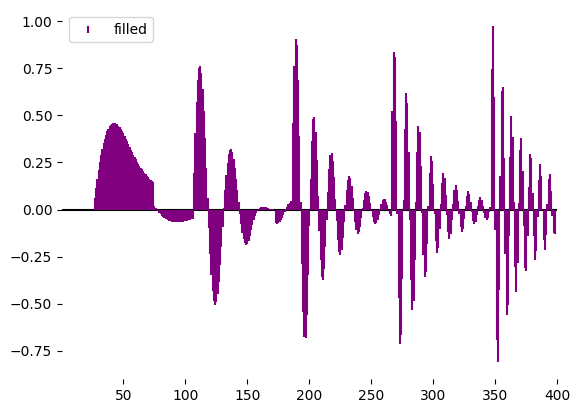

In [15]:
# Create the stem plot for the interpolated data
plot_interp = stems(miss, "filled", "purple")


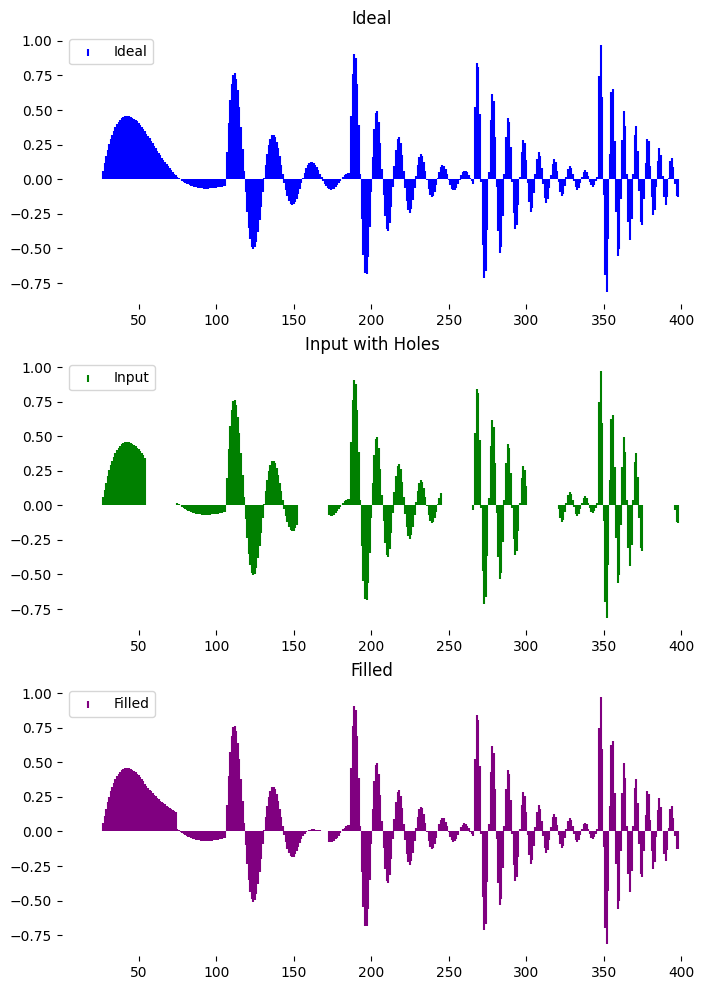

<Figure size 640x480 with 0 Axes>

In [16]:
# Create subplots with a layout of 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Adjust figsize as needed

# Plot the ideal data
axs[0].stem(inp, linefmt='blue', markerfmt=' ', basefmt=" ")
axs[0].set_title("Ideal")
axs[0].set_xlim([0.5, len(inp) + 0.5])
axs[0].legend(["Ideal"], loc='upper left')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Plot the input with holes
axs[1].stem(inp2, linefmt='green', markerfmt=' ', basefmt=" ")
axs[1].set_title("Input with Holes")
axs[1].set_xlim([0.5, len(inp2) + 0.5])
axs[1].legend(["Input"], loc='upper left')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

# Plot the interpolated data
axs[2].stem(miss, linefmt='purple', markerfmt=' ', basefmt=" ")
axs[2].set_title("Filled")
axs[2].set_xlim([0.5, len(miss) + 0.5])
axs[2].legend(["Filled"], loc='upper left')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)

f = plt.figure()


In [17]:
import zipfile


# Part 2

In [18]:
import requests
import os

# Download data from a public server
url = "https://zenodo.org/api/records/11099632/files-archive"
response = requests.get(url)
with open("files.zip", "wb") as file:
    file.write(response.content)

# Unzip the archive file
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    zip_ref.extractall("extracted_folder")  # Specify the directory to extract to


In [19]:
# Create a dictionary for easy access to files
patterns = {}

# Open the ZIP file and populate the dictionary
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    for file_info in zip_ref.infolist():
        name = os.path.splitext(file_info.filename)[0]
        patterns[name] = file_info

# Example usage: access a specific file from the dictionary
# file_obj = patterns['some_filename']


In [20]:
patterns

{'seis': <ZipInfo filename='seis.rsf@' filemode='?rw-------' file_size=125000>,
 'wood': <ZipInfo filename='wood.rsf@' filemode='?rw-------' file_size=65536>,
 'herr': <ZipInfo filename='herr.rsf@' filemode='?rw-------' file_size=65536>}

In [21]:
# Create a dictionary for easy access to files
patterns = {}

# Open the ZIP file and populate the dictionary
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    for file_info in zip_ref.infolist():
        name = os.path.splitext(file_info.filename)[0]
        patterns[name] = file_info.filename

# Example usage: access a specific file from the dictionary
# To read the content of a file named "wood":
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    with zip_ref.open(patterns["wood"]) as file:
        # Read the file content (for example, as bytes)
        data = file.read()
        # Convert the data to an appropriate format, if necessary
        # For example, you can convert it to a numpy array if it's numerical data
        wood = np.frombuffer(data, dtype=np.float32).reshape(128, 128,order='F')

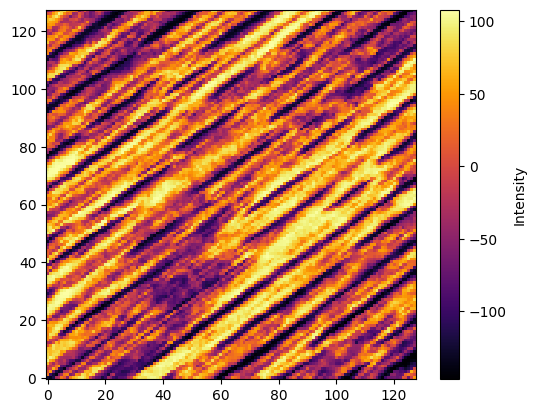

In [22]:
plt.imshow(wood, cmap='inferno', interpolation='none', origin="lower")
plt.colorbar(label='Intensity')  
plt.show()

In [23]:
def punch_hole(data):
    """
    Create an elliptical hole in the data.

    Parameters:
    data (np.ndarray): Input data matrix.

    Returns:
    tuple: (hole, mask) where `hole` is the data with an elliptical hole,
            and `mask` indicates where the hole was punched.
    """
    n1, n2 = data.shape
    hole = np.zeros_like(data, dtype=np.float32, order='F')
    mask = np.zeros((n1, n2), dtype=bool, order='F')

    for i2 in range(n2):
        for i1 in range(n1):
            # x = (i1 - 1) / n1 - 0.5
            # y = (i2 - 1) / n2 - 0.3
            x = (i1) / n1 - 0.5
            y = (i2) / n2 - 0.3
            u = x + y
            v = (x - y) / 2
            if u*u + v*v < 0.15:
                hole[i1, i2] = 0.0
            else:
                hole[i1, i2] = data[i1, i2]
                mask[i1, i2] = True

    return hole, mask

# Example usage with `wood` array
whole, wmask = punch_hole(wood)
np.save("./npy/p_whole.npy",whole)
np.save("./npy/p_wmask.npy",wmask)


In [24]:
# np.isfortran(whole)

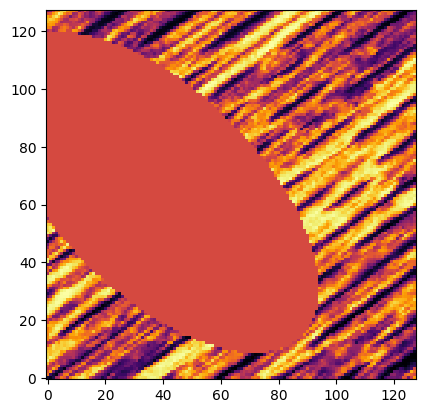

In [25]:
plt.imshow(whole, cmap='inferno', interpolation='none', origin="lower")


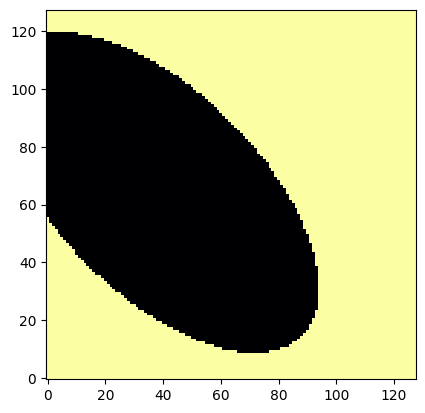

In [26]:
plt.imshow(wmask, cmap='inferno', interpolation='none', origin="lower")

In [27]:
def helix(lag, ci):
    """
    Convert filter lags to helix lags for a given grid.

    Args:
        lag: A list of tuples representing the filter lags.
        ci: A tuple representing the shape of the grid.

    Returns:
        A list of helix lags.
    """

    # Middle of the grid
    mid = (np.array(ci) // 2) -1

    # Helix index of middle
    linear_indices_ci = np.arange(ci.prod()).reshape(tuple(ci), order='F')

    hmid = linear_indices_ci[mid[0],mid[1]]


    # map = [l + mid for l in lag]
    map = lag + mid

    # values = [(linear_indices_ci[idx[0], idx[1]])-hmid for idx in map]
    values = linear_indices_ci[map[:, 0], map[:, 1]] - hmid
    return values

In [28]:
from numba import njit
import numpy as np

@njit
def stream_missing_helix_core(d, k, hlag, λ, std, maxlag, n1):
    na = len(hlag)
    a = np.zeros(na)
    da = 0.
    dd = 0.

    # Compute initial dd
    # dd seems ok
    for ia in range(na):
        dd += d[maxlag - hlag[ia]] ** 2

    sumrn = 0
    for i1 in range(maxlag, n1):
        if k[i1]:
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            sumrn += rn
        else:  # assume r_n is random
            # rn = std * np.random.randn() / λ
            # myrandom = fake_randomes[i1]
            myrandom = 0.26
            rn = std * myrandom / λ
            if i1 == maxlag+10:
                print(myrandom)
            dn = rn * (λ + dd) - da
            d[i1] = dn
            sumrn += rn

        # Update PEF
        for ia in range(na):
            if (i1 - hlag[ia]) >= 0:  # Ensure index is within bounds
                a[ia] -= rn * d[i1 - hlag[ia]]

        # Update dd and da
        if (i1 - maxlag) >= 0:  # Ensure index is within bounds
            dd += dn * dn - d[i1 - maxlag] * d[i1 - maxlag]
        da = dn * a[0]
        for ia in range(1, na):
            if (i1 + 1 - hlag[ia]) >= 0:  # Ensure index is within bounds
                da += a[ia] * d[i1 + 1 - hlag[ia]]
    print("sumrn : ", sumrn)

def stream_missing_helix(d_n_dim, k_n_dim, lag, λ, std=0, seed=1):
    "Fill missing data in multiple dimensions using streaming PEF on a helix"
    d = np.reshape(d_n_dim, -1, order='F')
    k = np.reshape(k_n_dim, -1, order='F')

    n1 = len(d)
    na = len(lag)
    ci = np.array(d_n_dim.shape, order='F')
    hlag = helix(lag, ci)
    np.save("./npy/p_hlag.npy",hlag)
    maxlag = np.max(hlag)

    # np.random.seed(seed)

    # Call the JIT-compiled core function
    d = stream_missing_helix_core(d, k, hlag, λ, std, maxlag, n1)

In [29]:
# 11 x 11 PEF
lag = [(x, 0) for x in range(1, 6)]
for k in range(1, 11):
    lag.extend([(x, k) for x in range(-5, 6)])
lag = np.array(lag)


In [30]:
# rnd_seed1 = np.load("./npy/random_numbers.npy")
# rnd_seed2 = np.load("./npy/random_numbers_seed2.npy")
# fake_randoms = np.empty_like(rnd_seed1)

In [31]:
def fill_hole(forward, hole, mask, pad, noise=0, seed=1):
    "Fill holes in data using forward or backward filling"
    np.save("./npy/p_first_hole.npy",hole)
    np.save("./npy/p_first_mask.npy",mask)

    if forward:
        # fake_randoms = rnd_seed1
        # Pad data with zeros on the left
        holepad = np.hstack([np.zeros((hole.shape[0], pad), dtype=np.float32, order="F"), hole])
        np.save("./npy/p_holepad.npy", holepad)
        np.save("./npy/p_hole.npy", hole)

        maskpad = np.hstack([np.zeros((mask.shape[0], pad), dtype=bool, order="F"), mask])
        np.save("./npy/p_maskpad.npy", maskpad)

        # Fill missing data
        stream_missing_helix(holepad, maskpad, lag, 1e6, noise, seed)

        # Return data without the padding
        return holepad[:, pad:]

    else:
        # fake_randoms = rnd_seed2
        # Reverse the data
        rhole = np.asfortranarray(np.flip(hole))
        # rhole = np.asfortranarray(np.flip(hole,axis=1))
        np.save("./npy/p_rhole.npy",rhole)

        rmask = np.asfortranarray(np.flip(mask))
        # rmask = np.asfortranarray(np.flip(mask,axis=1))
        np.save("./npy/p_rmask.npy",rmask)

        # Pad reversed data with zeros on the left
        holepad = np.hstack([np.zeros((rhole.shape[0], pad), dtype=np.float32, order="F"), rhole])
        np.save("./npy/p_else_holepad.npy", holepad)
        maskpad = np.hstack([np.zeros((rmask.shape[0], pad), dtype=bool, order="F"), rmask])
        np.save("./npy/p_else_maskpad.npy", maskpad)

        # Fill missing data
        stream_missing_helix(holepad, maskpad, lag, 1e6, noise, seed + 1)

        # Return reversed filled data
        # return np.flip(holepad[:, pad:], axis=1)
        return np.asfortranarray(np.flip(holepad[:, pad:]))


In [32]:
np.save("./npy/p_whole_before.npy",whole)
filled1 = fill_hole(True, whole, wmask, 20)
np.save("./npy/p_filled1.npy",filled1)
filled2 = fill_hole(False, whole, wmask, 20)
np.save("./npy/p_filled2.npy",filled2)

0.26
sumrn :  0.0028180669014537213
0.26
sumrn :  -0.00028144799957502013


In [33]:
def plot2(ax, data, title):
    # Display heatmap on the provided axis
    # im = ax.imshow(data, cmap='gray', vmin=-137, vmax=137, origin='upper')
    im = ax.imshow(data, cmap='gray', vmin=-137, vmax=137)
    ax.set_title(title)
    # ax.axis('off')  # Remove axis labels and ticks
    return im  # Return the image for adding colorbars if needed

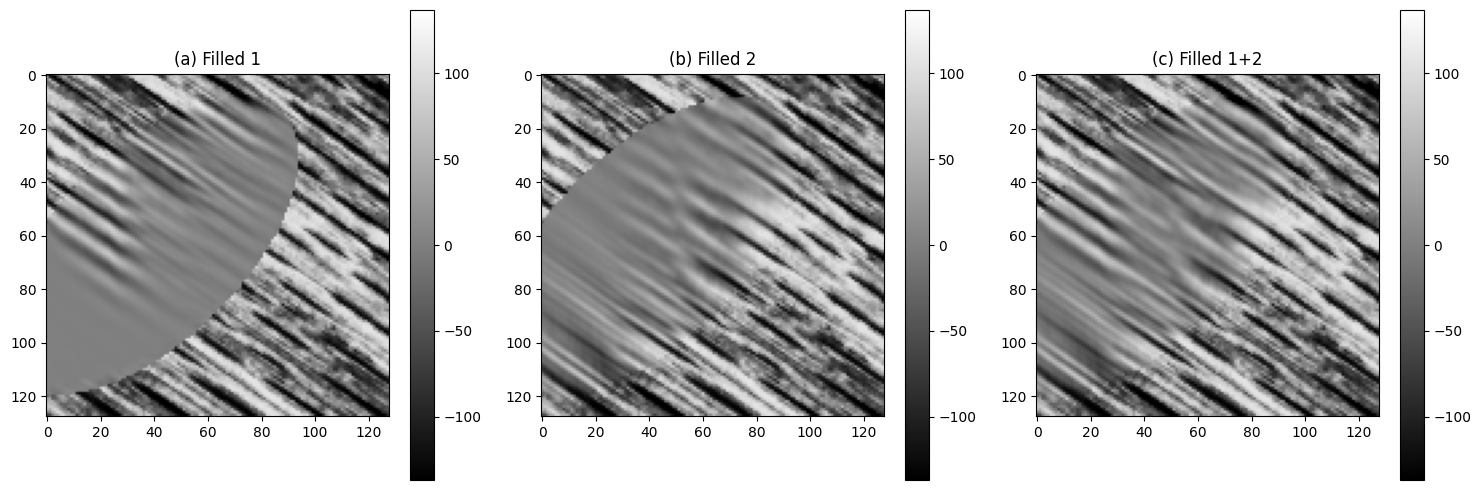

In [34]:
# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the three images
im1 = plot2(ax1, filled1, "(a) Filled 1")
im2 = plot2(ax2, filled2, "(b) Filled 2")
im3 = plot2(ax3, filled1 + filled2 - whole, "(c) Filled 1+2")

np.save("./npy/p_p3.npy",filled1+filled2-whole)

# Add a colorbar for each subplot (optional)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Adjust layout
plt.tight_layout()
plt.show()

0.26
sumrn :  nan
0.26
sumrn :  nan


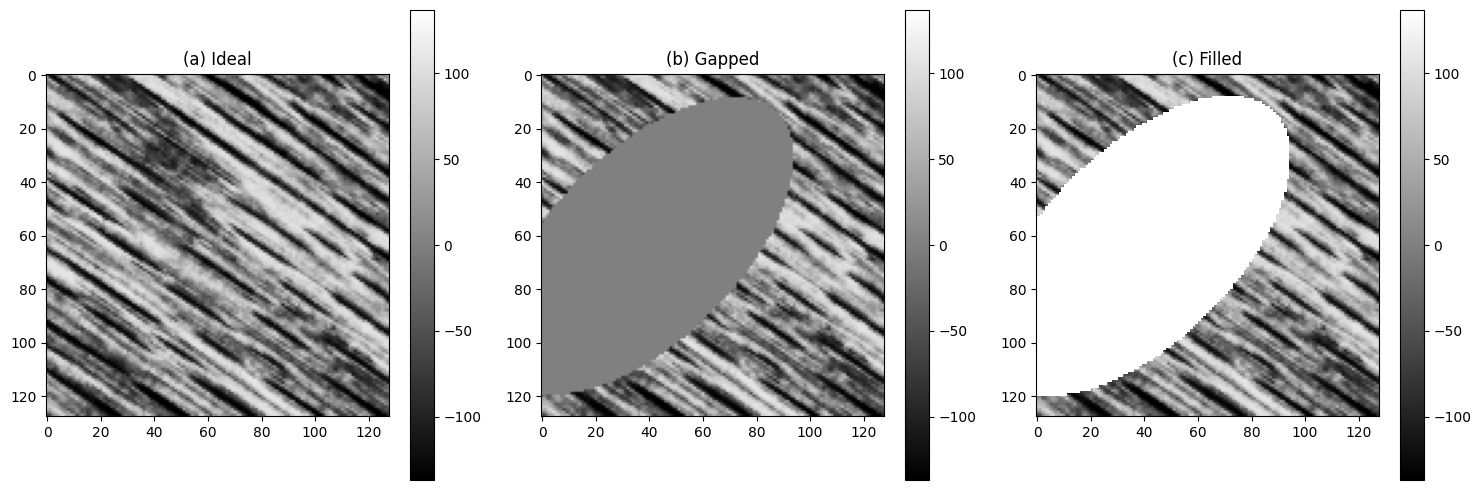

In [35]:
# Fill the hole (similar to your Julia code)
filled = fill_hole(True, whole, wmask, 20, 2) + fill_hole(False, whole, wmask, 20, 2) - whole

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the three images
im1 = plot2(ax1, wood, "(a) Ideal")
im2 = plot2(ax2, whole, "(b) Gapped")
im3 = plot2(ax3, filled, "(c) Filled")

# Add a colorbar for each subplot (optional)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Adjust layout
plt.tight_layout()
plt.show()


In [36]:
# p = Array{Plots.Plot}(undef,3)
# for k in 1:3
#     filled = fill_hole(true,  whole, wmask, 20, 2, k) +
#              fill_hole(false, whole, wmask, 20, 2, k+3) - whole
#     p[k] = plot2(filled, "Realization $k")
# end
# plot(p[1], p[2], p[3], layout=(1, 3))

0.26
sumrn :  nan
0.26
sumrn :  nan
0.26
sumrn :  nan
0.26
sumrn :  nan
0.26
sumrn :  nan
0.26
sumrn :  nan


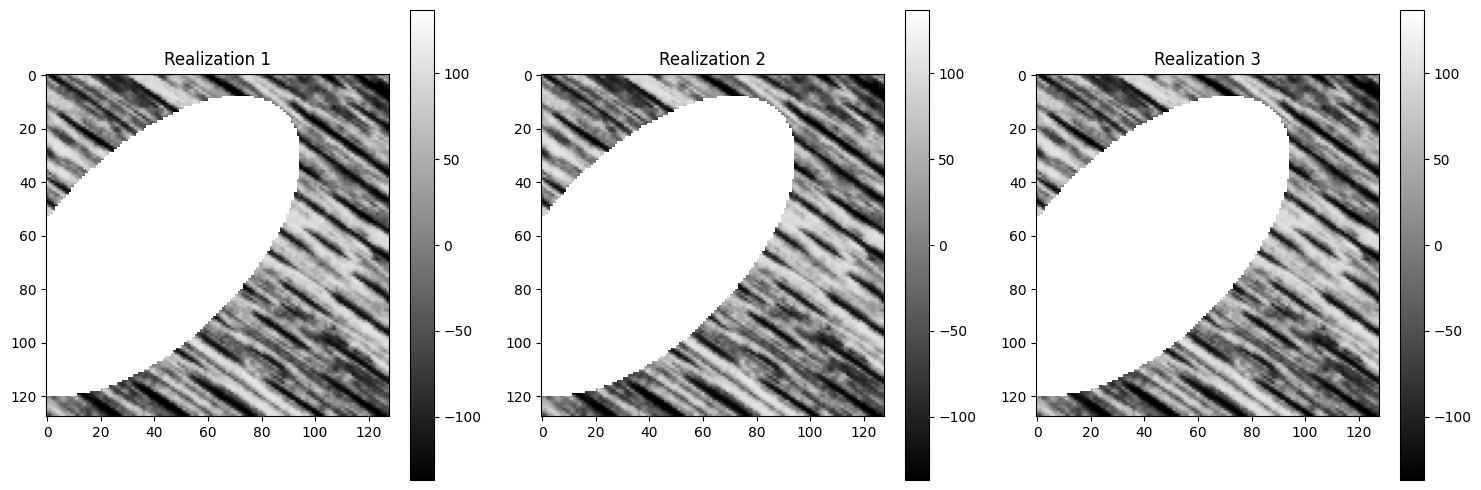

In [37]:
images = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for k in range(1,4):
    filled = fill_hole(True,  whole, wmask, 20, 2, k) + fill_hole(False, whole, wmask, 20, 2, k+3) - whole 
    images.append(plot2(axes[k-1], filled, f"Realization {k}"))
    fig.colorbar(images[k-1], ax=axes[k-1])

# Adjust layout
plt.tight_layout()
plt.show()

In [38]:

# Create a 128x128 array for the "herring" pattern
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    with zip_ref.open(patterns["herr"]) as file:
        # Read the file content (for example, as bytes)
        data = file.read()
        # Convert the data to an appropriate format, if necessary
        # For example, you can convert it to a numpy array if it's numerical data
        herr = np.frombuffer(data, dtype=np.float32).reshape(128, 128, order="F")


np.save("./npy/p_herr.npy",herr)
# Make a hole in the pattern using the punch_hole function
hhole, hmask = punch_hole(herr)
np.save("./npy/p_hhole.npy",hhole)
np.save("./npy/p_hmask.npy",hmask)

0.26
sumrn :  nan
0.26
sumrn :  nan


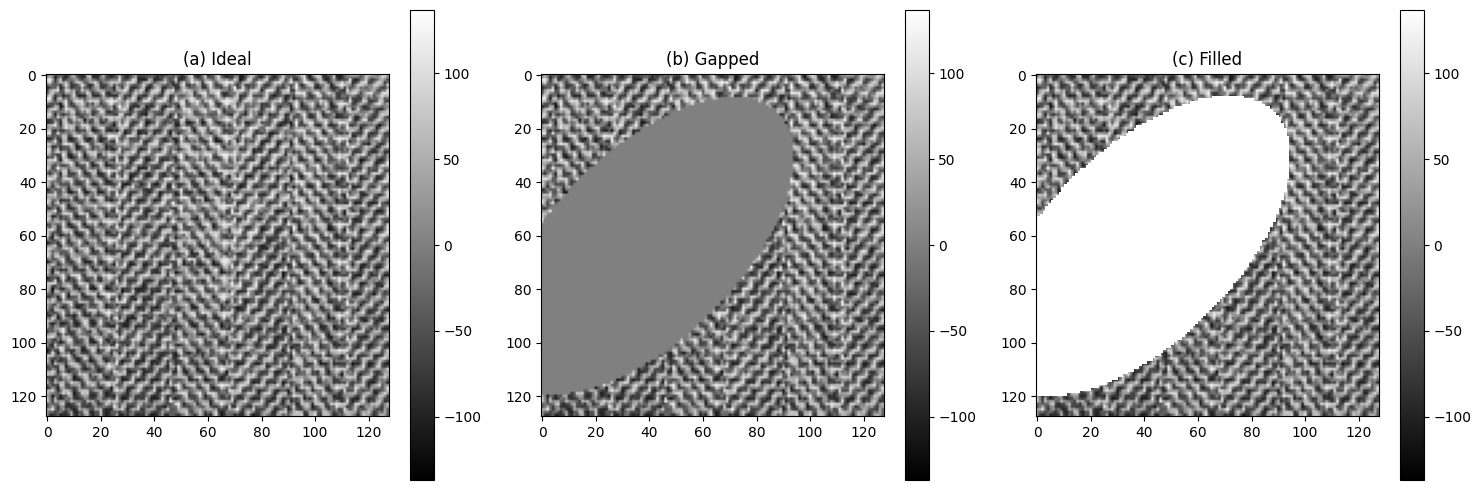

In [39]:
# Fill the hole using forward and backward filling
filled = (
    fill_hole(True, hhole, hmask, 20, 6) +
    fill_hole(False, hhole, hmask, 20, 6) - hhole
)

# Assuming 'herr', 'hhole', and 'filled' are already defined

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the three images
im1 = plot2(ax1, herr, "(a) Ideal")
im2 = plot2(ax2, hhole, "(b) Gapped")
im3 = plot2(ax3, filled, "(c) Filled")

# Add a colorbar for each subplot (optional)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Adjust layout
plt.tight_layout()
plt.show()


In [40]:
# "seismic" pattern
seis_base = np.empty((250, 125), dtype=np.float32)  # single-precision array

# Read the seismic pattern data from the zip file
with zipfile.ZipFile("files.zip", "r") as zip_ref:
    with zip_ref.open(patterns["seis"]) as file:
        # Read the file content (assuming it's binary data)
        data = file.read()
        # Convert the data to a numpy array
        seis_base = np.frombuffer(data, dtype=np.float32).reshape((250, 125), order="F")

np.save("./npy/p_seis_base.npy", seis_base)


In [41]:
# Normalize the seismic pattern
seis = seis_base.copy()
m = np.mean(seis)
seis -= m
scale = np.std(wood) / np.std(seis)
seis *= scale
np.save("./npy/p_seis.npy", seis)

# Make a hole in the seismic pattern
shole, smask = punch_hole(seis)
np.save("./npy/p_shole.npy", shole)
np.save("./npy/p_smask.npy", smask)


0.26
sumrn :  0.0015572128039407769
0.26
sumrn :  0.002025892751534131


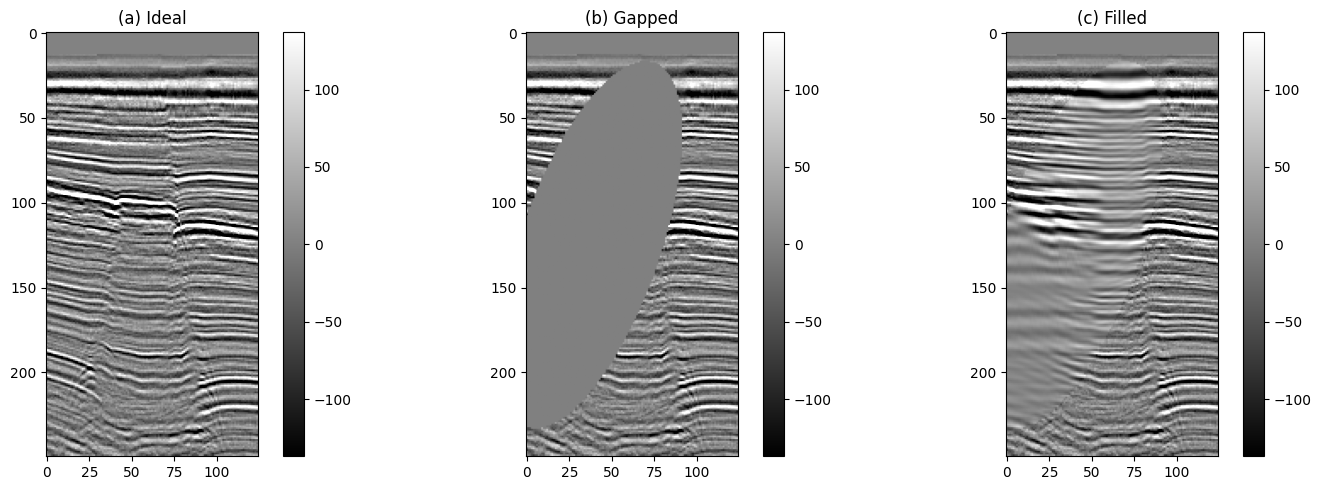

In [42]:
# Fill the hole in the seismic pattern
filled = fill_hole(True, shole, smask, 20, 0.7) + \
         fill_hole(False, shole, smask, 20, 0.7) - shole

# Create the plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the three images
im1 = plot2(ax1, seis, "(a) Ideal")
im2 = plot2(ax2, shole, "(b) Gapped")
im3 = plot2(ax3, filled, "(c) Filled")

# Add a colorbar for each subplot (optional)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Adjust layout
plt.tight_layout()
plt.show()


In [43]:
import numpy as np
from numba import njit

@njit
def stream_helix_core(inv, d, r, hlag, lambd, maxlag, n1, na):
    T = d.dtype
    a = np.zeros(na, dtype=T)  # streaming PEF

    # Initialize values
    for i1 in range(maxlag):
        if inv:
            d[i1] = r[i1]
        else:
            r[i1] = d[i1]

    da = 0  # d (dot) a
    dd = 0  # d (dot) d

    for ia in range(na):
        dd += d[maxlag + 1 - hlag[ia]] ** 2

    for i1 in range(maxlag, n1):
        if inv:
            rn = r[i1] / lambd
            dn = rn * (lambd + dd) - da
            d[i1] = dn
        else:
            dn = d[i1]
            rn = (dn + da) / (lambd + dd)
            r[i1] = lambd * rn

        # Update PEF
        for ia in range(na):
            a[ia] -= rn * d[i1 - hlag[ia]]

        # Update dd and da
        dd += dn * dn - d[i1 - maxlag] * d[i1 - maxlag]
        da = dn * a[0]

        for ia in range(1, na):
            da += a[ia] * d[i1 + 1 - hlag[ia]]

def stream_helix(inv, d_n_dim, r_n_dim, lag, lambd):
    d = np.reshape(d_n_dim, -1, order='F')
    r = np.reshape(r_n_dim, -1, order='F')

    n1, na = len(d), len(lag)
    hlag = helix(lag, np.array(d_n_dim.shape))
    maxlag = np.max(hlag)

    # Call the JIT-compiled core function
    d, r = stream_helix_core(inv, d, r, hlag, lambd, maxlag, n1, na)

    # Reshape d and r back to their original shapes
    d_n_dim = np.reshape(d, d_n_dim.shape, order='F')
    r_n_dim = np.reshape(r, r_n_dim.shape, order='F')

In [44]:
# Apply helix filter
pad = np.hstack((np.zeros((seis.shape[0], 20), dtype=np.float32, order="F"), seis))
res = np.empty_like(pad)

# Forward filtering
stream_helix(False, pad, res, lag, 1e6)  # pad -> res

# Backward filtering
stream_helix(True, pad, res, lag, 1e6)   # pad <- res


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

im1 = plot2(ax1, seis, "(a) Input")
im2 = plot2(ax2, 20 * res[:, 20:], "(b) Residual (x 20)")
im3 = plot2(ax3, pad[:, 20:], "(c) Inverse")

# Add a colorbar for each subplot (optional)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Adjust layout
plt.tight_layout()
plt.show()


# TMP ZONE


# old code


In [1090]:
# def stream_missing_helix(d_n_dim, k_n_dim, lag, λ, std=0, seed=1):
#     "Fill missing data in multiple dimensions using streaming PEF on a helix"
#     d = np.reshape(d_n_dim,-1,order='F')
#     k = np.reshape(k_n_dim,-1,order='F')


#     n1 = len(d)
#     na = len(lag)
#     ci = np.array(d_n_dim.shape, order='F')
#     hlag = helix(lag, ci)
#     maxlag = np.max(hlag)

#     a = np.zeros(na, order='F')  # streaming PEF
#     da = 0.  # d (dot) a
#     dd = 0.  # d (dot) d

#     # Compute initial dd
#     for ia in range(na):
#         # i1, i2 = np.unravel_index(maxlag - hlag[ia],d.shape)
#         dd += d[maxlag - hlag[ia]] ** 2
#         # dd += d[i1,i2]

#     np.random.seed(seed)

#     ################################################################### OLD
#     for i1 in range(maxlag, n1):
#         if k[i1]:
#             dn = d[i1]
#             rn = (dn + da) / (λ + dd)
#         else:  # assume r_n is random
#             rn = std * np.random.randn() / λ
#             dn = rn * (λ + dd) - da
#             d[i1] = dn

#         # Update PEF
#         for ia in range(na):
#             if (i1 - hlag[ia]) >= 0:  # Ensure index is within bounds
#                 a[ia] -= rn * d[i1 - hlag[ia]]

#         # Update dd and da
#         if (i1 - maxlag) >= 0:  # Ensure index is within bounds
#             dd += dn * dn - d[i1 - maxlag] * d[i1 - maxlag]
#         da = dn * a[0]
#         for ia in range(1, na):
#             if (i1 + 1 - hlag[ia]) >= 0:  # Ensure index is within bounds
#                 da += a[ia] * d[i1 + 1 - hlag[ia]]
#     ################################################################### OLD


In [1091]:
# def stream_helix(inv, d_n_dim, r_n_dim, lag, lambd):
#     # d = d_n_dim.reshape(-1)
#     # r = r_n_dim.reshape(-1)
#     d = np.reshape(d_n_dim,-1,order='F')
#     r = np.reshape(r_n_dim,-1,order='F')

#     n1, na = len(d), len(lag)
#     # print(f"{np.indices(d.shape)=}")
#     # hlag = helix(lag, np.indices(d.shape))
#     print(f"{d_n_dim.shape=}")
#     hlag = helix(lag, np.array(d_n_dim.shape))
#     maxlag = np.max(hlag)
#     T = d.dtype
#     a = np.zeros(na, dtype=T)  # streaming PEF

#     # Initialize values
#     for i1 in range(maxlag):
#         if inv:
#             d[i1] = r[i1]
#         else:
#             r[i1] = d[i1]

#     da = 0  # d (dot) a
#     dd = 0  # d (dot) d

#     for ia in range(na):
#         dd += d[maxlag + 1 - hlag[ia]] ** 2

#     for i1 in range(maxlag, n1):
#         if inv:
#             rn = r[i1] / lambd
#             dn = rn * (lambd + dd) - da
#             d[i1] = dn
#         else:
#             dn = d[i1]
#             rn = (dn + da) / (lambd + dd)
#             r[i1] = lambd * rn

#         # Update PEF
#         for ia in range(na):
#             a[ia] -= rn * d[i1 - hlag[ia]]

#         # Update dd and da
#         dd += dn * dn - d[i1 - maxlag] * d[i1 - maxlag]
#         da = dn * a[0]

#         for ia in range(1, na):
#             da += a[ia] * d[i1 + 1 - hlag[ia]]
